# Electromiografía: Análisis espectral.

## Flores Oliva Alejandro Elliot
###### Licenciatura en Física Biomédica en Ciencias Biológicas , Facultad de Ciencias, Universidad Nacional Autónoma de México.

## Índice:

[Resumen.](#Resumen)

[Obtención y visualización de señales electromiográficas.](#Obtenciónyvisualización)

[Espectro de Potencia.](#EspectrodePotencia)


<a id='Resumen'></a>
## Resumen
Análisis Espectral (Fourier) sirve para analizar una serie de tiempo pero en el dominio de la frecuencia, ya que todos los análisis que se han desarrollado hasta el momento son análisis en el dominio del tiempo.  El análisis espectral tiene el fundamento de transformar la serie de tiempo a una representación en términos de  componentes periódicas, también nos permite modelar diferentes tipos de ruido.

Este análisis utiliza el teorema de Fourier el cual menciona que  cualquier función periódica puede ser descrita como una suma (infinita) de funciones armónicas (senosoidales).Este análisis permite tener un dominio de la frecuencia, permite representar de otra manera  cualquier señal en términos de las  amplitudes de cada una de sus frecuencias componentes. La transformada de Fourier representa una señal en el  dominio de la frecuencia empleando una frecuencia que varía continuamente.

#### Librerías utilizadas 

Importamos las librerías/ módulos que nos permitirán hacer cálculos, filtrar datos, utilizar filtros, análisis, etc.

In [25]:
import math            #Permite usar funciones matemáticas definidas en el estándar de C.
import numpy as np     #Creación de vectores y matrices multidimensionales,permite usar otras funciones matemáticas.
import os              #Interfaces misceláneas del sistema operativo.
import pandas as pd    #Sirve para el manejo y análisis de estructuras de datos.
import scipy as sc     #Funciones importadas de numpy.
from scipy import signal#Herramientas de procesamiento de señales, funciones de filtrado, algoritmos de interpolación.
from scipy.fftpack import fft #Devuelve la transformada discreta de Fourier de secuencia real o compleja.
from scipy.signal import butter, lfilter, filtfilt
import wave            #El módulo proporciona una interfaz para el formato de sonido WAV.
import warnings
warnings.filterwarnings('ignore')  #suprimir la advertencia de diseño estrecho
from scipy.fft import fftshift
import matplotlib.pyplot as plt

#### Comandos para configuración de las imágenes/gráficos 

Configuramos para ver las figuras en notebook, creación de etiquetas, módulos para la creación de trazos.

In [26]:
# Comando para ver figuras en el cuaderno Jupyter.
%matplotlib inline 

# Módulo de trazado.
import matplotlib.pyplot as plt 

# Comandos para crear figuras de alta resolución con etiquetas grandes.
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 18                #Tamaño de fuente para etiquetas de figuras.
plt.rcParams['axes.titlesize'] = 20                #Tamaño de fuente para títulos de figuras.
plt.rcParams['font.size'] = 16                     #Tamaño de fuente para números de figura.
plt.rcParams['lines.linewidth'] = 1.6              #Ancho de línea para trazar

<a id='Obtenciónyvisualización'></a>
## Obtención y visualización de señales electromiográficas

##### Extraer y graficar los datos

Las grabaciones de EMG se obtuvieron utilizando Backyard Brains EMG Spiker Box y se guardan como archivos de audio en formato .wav. Utilizando las librerías para visualizar nuestros datos, posteriormente con el uso de otros comandos almacenaremos los resultados relevantes para los cálculos/ análisis posteriores.

In [30]:
def EMG(archivo,graph):
    
    # Visualización del archivo .wav, es necesario saber la ubicación del archivo y su nombre.
    #Los archivos WAV contienen una secuencia de bits que representan los datos de audio sin procesar.
    record = wave.open(archivo)
    
    #Obtención del número de canales, frecuencia de muestreo, número de fotogramas. 
    NumCanales = record.getnchannels()      #Número de canales y retorna el número de canales de audio. 
    N= record.getnframes()                  #Número de fotogramas.
    FrecMuestreo = record.getframerate()    #Retorna la frecuencia del muestreo.
    AnchoMuestra=record.getsampwidth()      #Retorna el ancho de la muestra en bytes.
    
    #Análisis de datos del archivo .wav
    dstr = record.readframes(N * NumCanales) #Lee y retorna como máximo n cuadros de audio, como un objeto bytes.
    waveData = np.frombuffer(dstr, np.int16) #np.frombuffer es una función para crear una matriz unidimensional utilizando un búfer. 
    #El módulo de ondas "wave" proporciona una interfaz conveniente para el formato de sonido WAV. 
    
    #Imprimimos el número de canales, la frecuencia de muestreo y el ancho de muestra.
    #print('La grabación tiene %d canal(ó canales).' % (NumCanales))
    #print('La frecuencia de muestreo de la grabación es %d Hz.' % (FrecMuestreo))
    #print('La grabación tiene un ancho de muestra de %d' % (AnchoMuestra))
    
    #Calcular la ventana, se utiliza la función linspace para crear matrices con valores espaciados uniformemente, esta 
    #función utiliza una matriz con 5 valores que se encuentren entre 0 y 2.
    EMGtiempo=np.linspace(0, len(waveData)/FrecMuestreo, num=len(waveData))
    
    #Calcular la frecuencia.
    frec = 1/np.mean(np.diff(EMGtiempo))
    
    #Filtro Butterworth de paso de banda a 10-400Hz.
    b, a = butter(2, ([10, 400]/(frec/2)), btype = 'bandpass')
    dataf = filtfilt(b, a, waveData)
    
    
    #Rectificar la señal EMG filtrada.
    AbsSeñal = np.absolute(dataf)
    Abstiempo=np.linspace(0, len(AbsSeñal)/FrecMuestreo, num=len(AbsSeñal))
    
    
    #Filtro Butterworth de paso bajo para detección de envolvente.
    lowp = 8
    sfrec = FrecMuestreo
    low_pass = lowp/sfrec
    b, a = sc.signal.butter(4, low_pass, btype='lowpass')
    datafrle = filtfilt(b, a, AbsSeñal)
    
    #Guardamos los datos más relevantes en una matriz.
    SeñalRelevante={'FrecMuestreo':FrecMuestreo,\
        'waveData':waveData,\
        'EMGtiempo':EMGtiempo,\
        'frec':frec,\
        'dataf':dataf,\
        'AbsSeñal':AbsSeñal,\
        'Abstiempo':Abstiempo,\
        'datafrle':datafrle} 
    
    #Graficamos EMG.   
   
    if graph:
        
        fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (20,15))

        #Trazar datos filtrados.
        ax1.plot(EMGtiempo,dataf, 'black')
        ax1.set_title('Datos sin procesar', fontsize=20)
        ax1.set_xlim(0,max(EMGtiempo))
        ax1.set_xlabel('Tiempo (s)')
        ax1.set_ylabel('Voltaje ($\mu$V)')
        
        #Trazar datos rectificados con envolvente.
        ax2.plot(Abstiempo,datafrle*3, 'purple', linewidth=2.5)# multiplique para que encajan los datos
        ax2.plot(Abstiempo,AbsSeñal, 'gray', alpha=0.4)
        ax2.set_title('EMG rectificada con sobre', fontsize=20)
        ax2.set_xlim(0,max(EMGtiempo))
        ax2.set_xlabel('Tiempo (s)')
        ax2.set_ylabel('Voltaje ($\mu$V)')
        
        #Trazar la envolvente con umbral potencial.
        ax3.plot(Abstiempo,datafrle, 'purple')
        ax3.set_title('EMG envoltura', fontsize=20)
        ax3.set_xlim(0,max(EMGtiempo))
        ax3.set_xlabel('Tiempo (s)')

        #espaciado entre trazos
        plt.tight_layout(pad=3.0)
        
    return SeñalRelevante

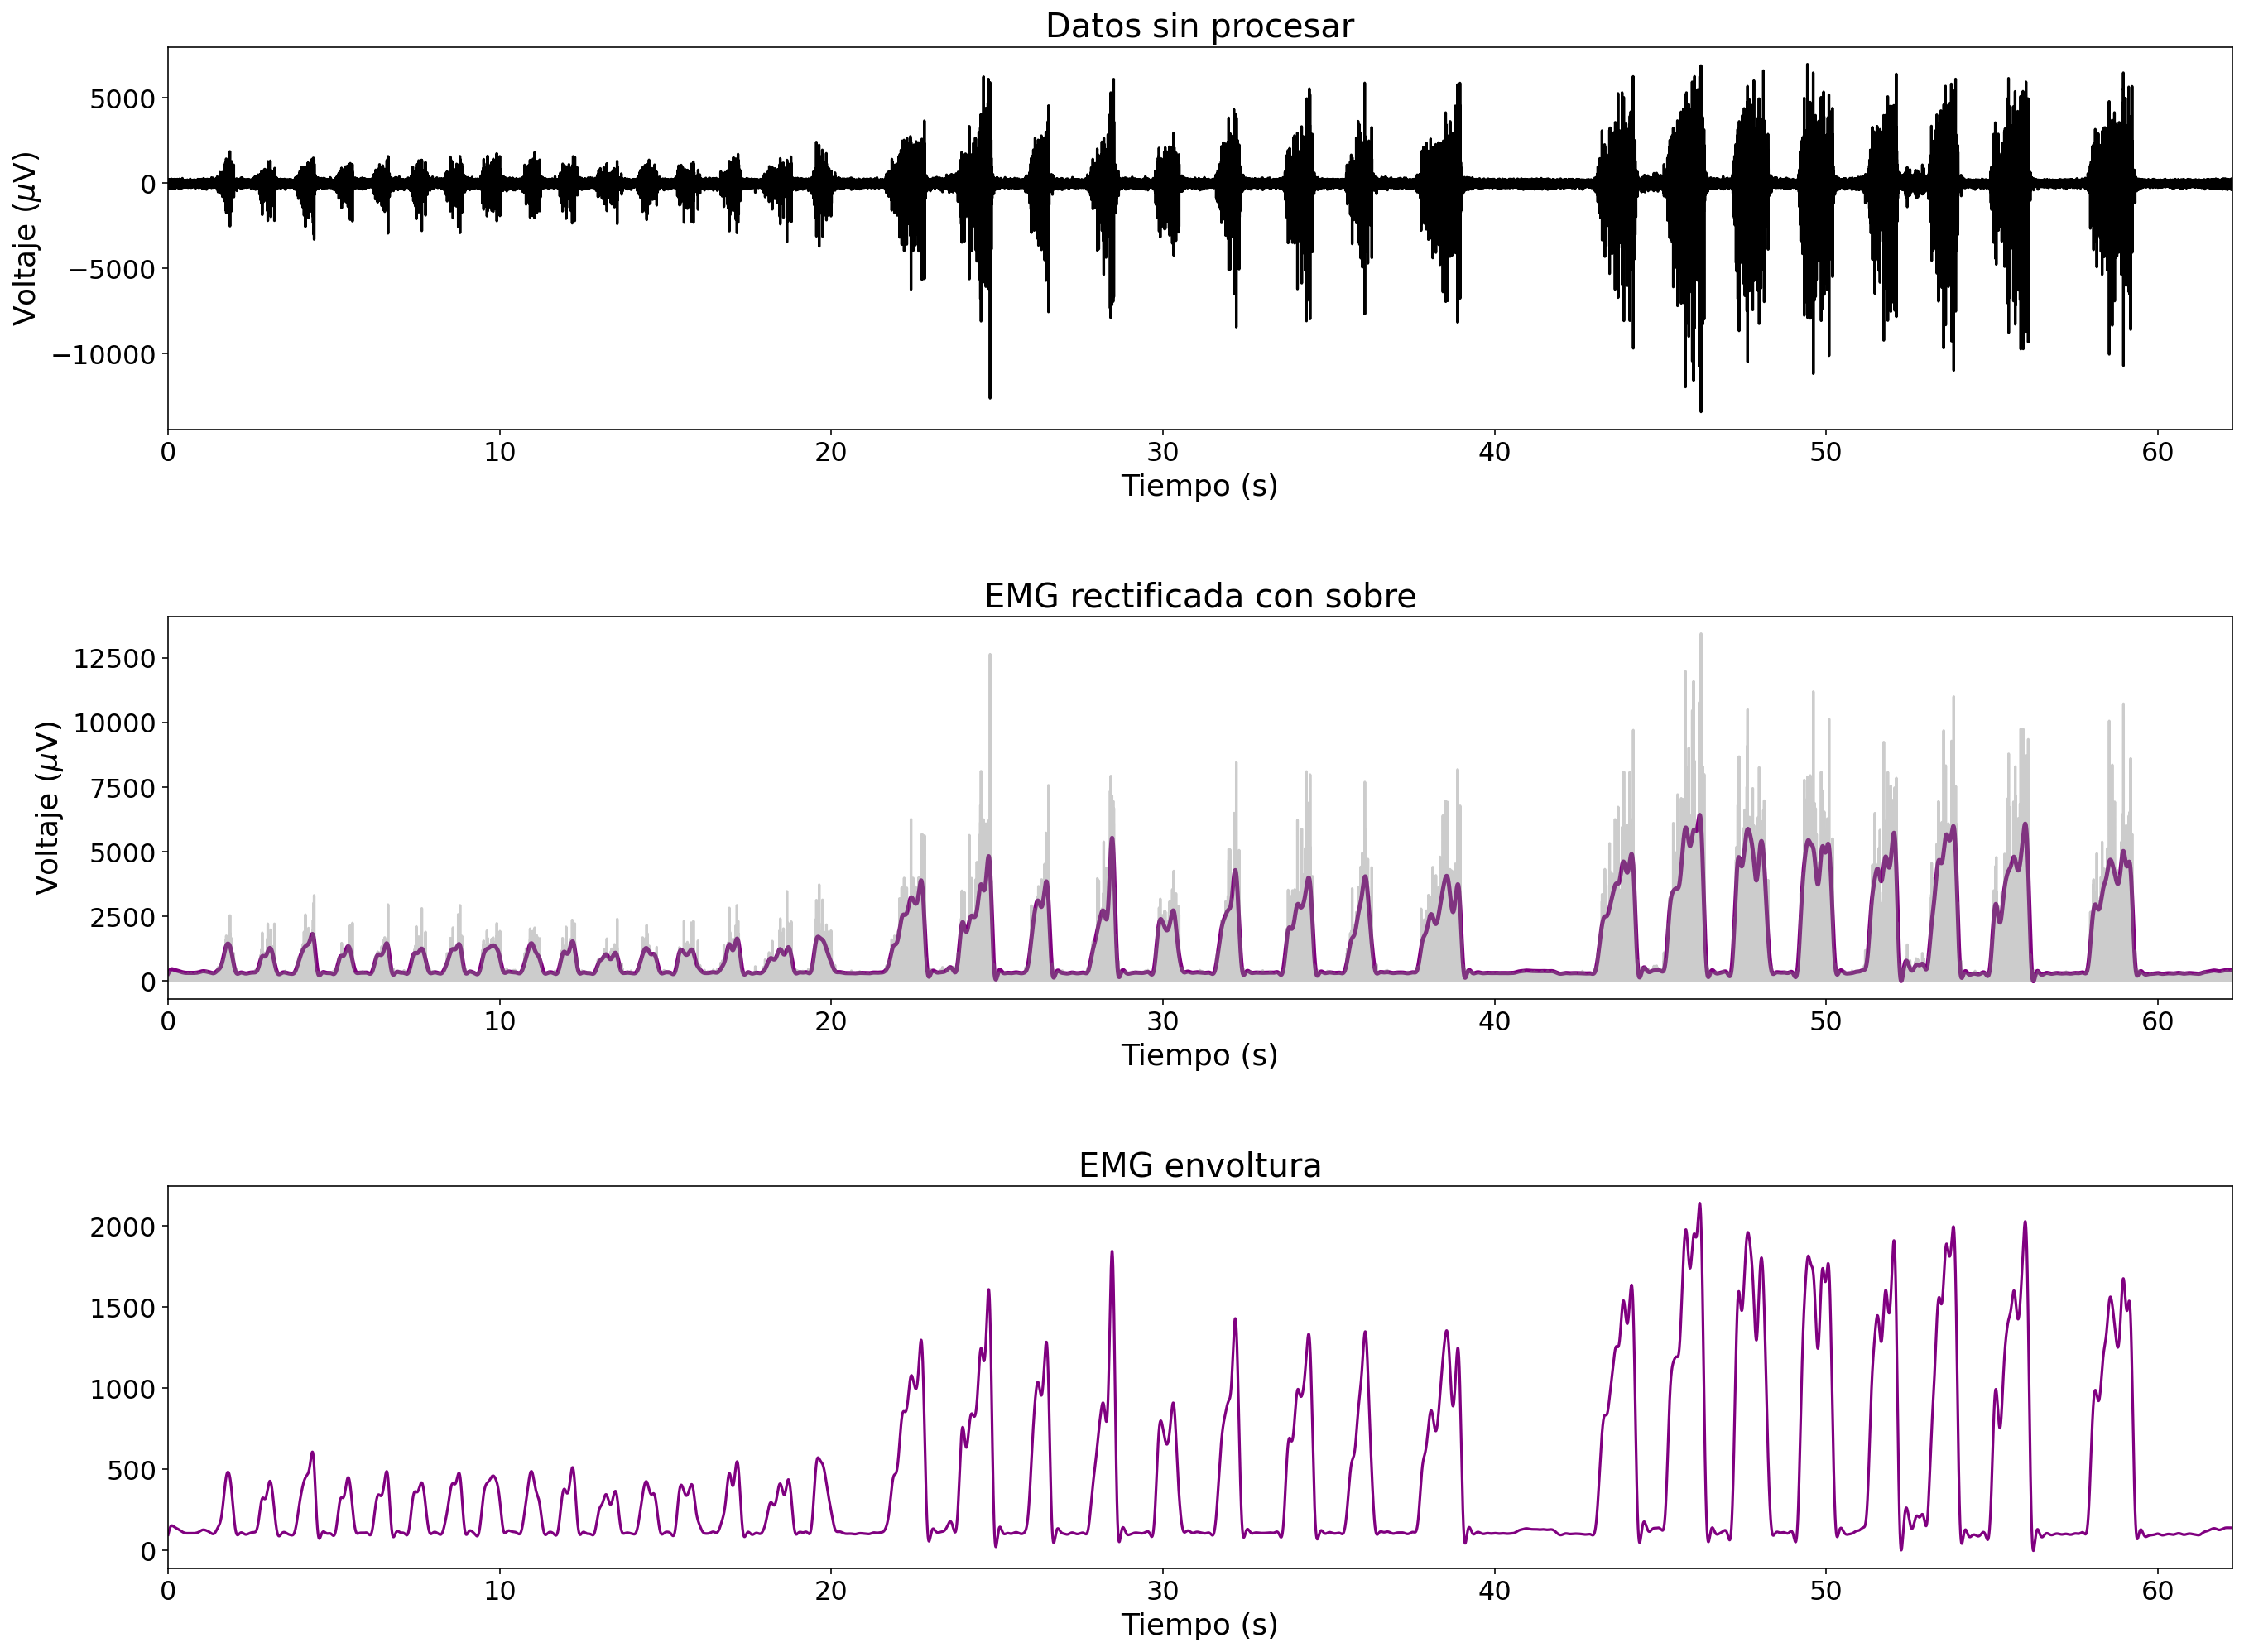

In [31]:
SeñalRelevante = EMG(archivo='../Registros/S1_EMG_rightHand_gripIntermittent.wav',graph=1)

Los espectrogramas se pueden utilizar como una forma de visualizar el cambio del contenido de frecuencia de una señal no estacionaria a lo largo del tiempo.

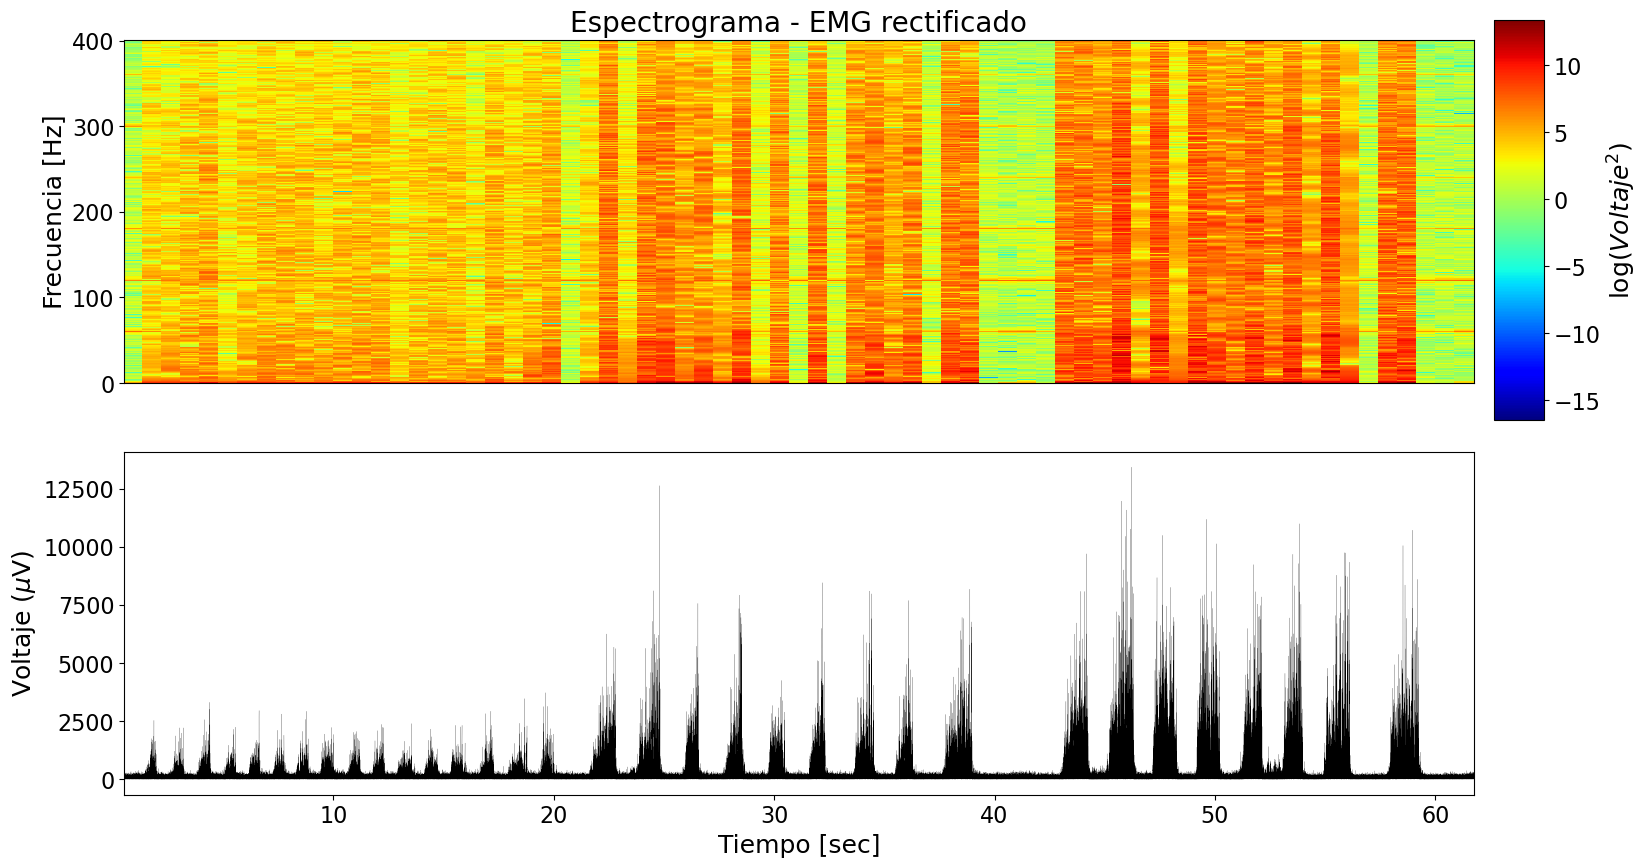

In [33]:
data = SeñalRelevante['AbsSeñal']
f,t,sxx = sc.signal.spectrogram(data,SeñalRelevante['FrecMuestreo'],nperseg=SeñalRelevante['FrecMuestreo'],\
                                scaling='spectrum')
f = f[:401]
sxx = sxx[:401]

#Tamaño de la figura.
fig = plt.figure(figsize=(20,10),dpi=50)

#Trazamos la señal rectificada.
ax2 = plt.subplot(212)
plt.plot(np.arange(0,len(data))/SeñalRelevante['FrecMuestreo'],data,lw=.1,color='black')
plt.ylabel('Voltaje ($\mu$V)')
plt.xlabel('Tiempo [sec]')
plt.xlim(t[0],t[-1])

#Trazamos el espectrograma con la señal rectificada. 
ax1 = plt.subplot(211)
plt.pcolormesh(np.log(sxx),cmap='jet')
plt.xticks([])
plt.ylabel('Frecuencia [Hz]')
plt.title('Espectrograma - EMG rectificado')

#Agregamos un eje independiente para la barra de colores.
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([.81, .5, 0.025, 0.4])
plt.colorbar(label='log($Voltaje^2$)',cax=cbar_ax,)

plt.draw()

En el espectrograma alcanza valores más altos asociados a la frecuencia (área naranja), esto se puede observar a lo largo de toda la banda de frecuencia (0-400 Hz). La diferencia en los colores del espectrograma nos dicen que hay mayor contenido de potencia aportado por la frecuencia cuando se acerca al color rojo, vemos que en diferentes momentos a lo largo del tiempo el espectrograma tiene una colorimetría roja que representa  zonas de actividad muscular momentánea.  

Graficar dos señales rectificadas y su respectivo espectrograma.

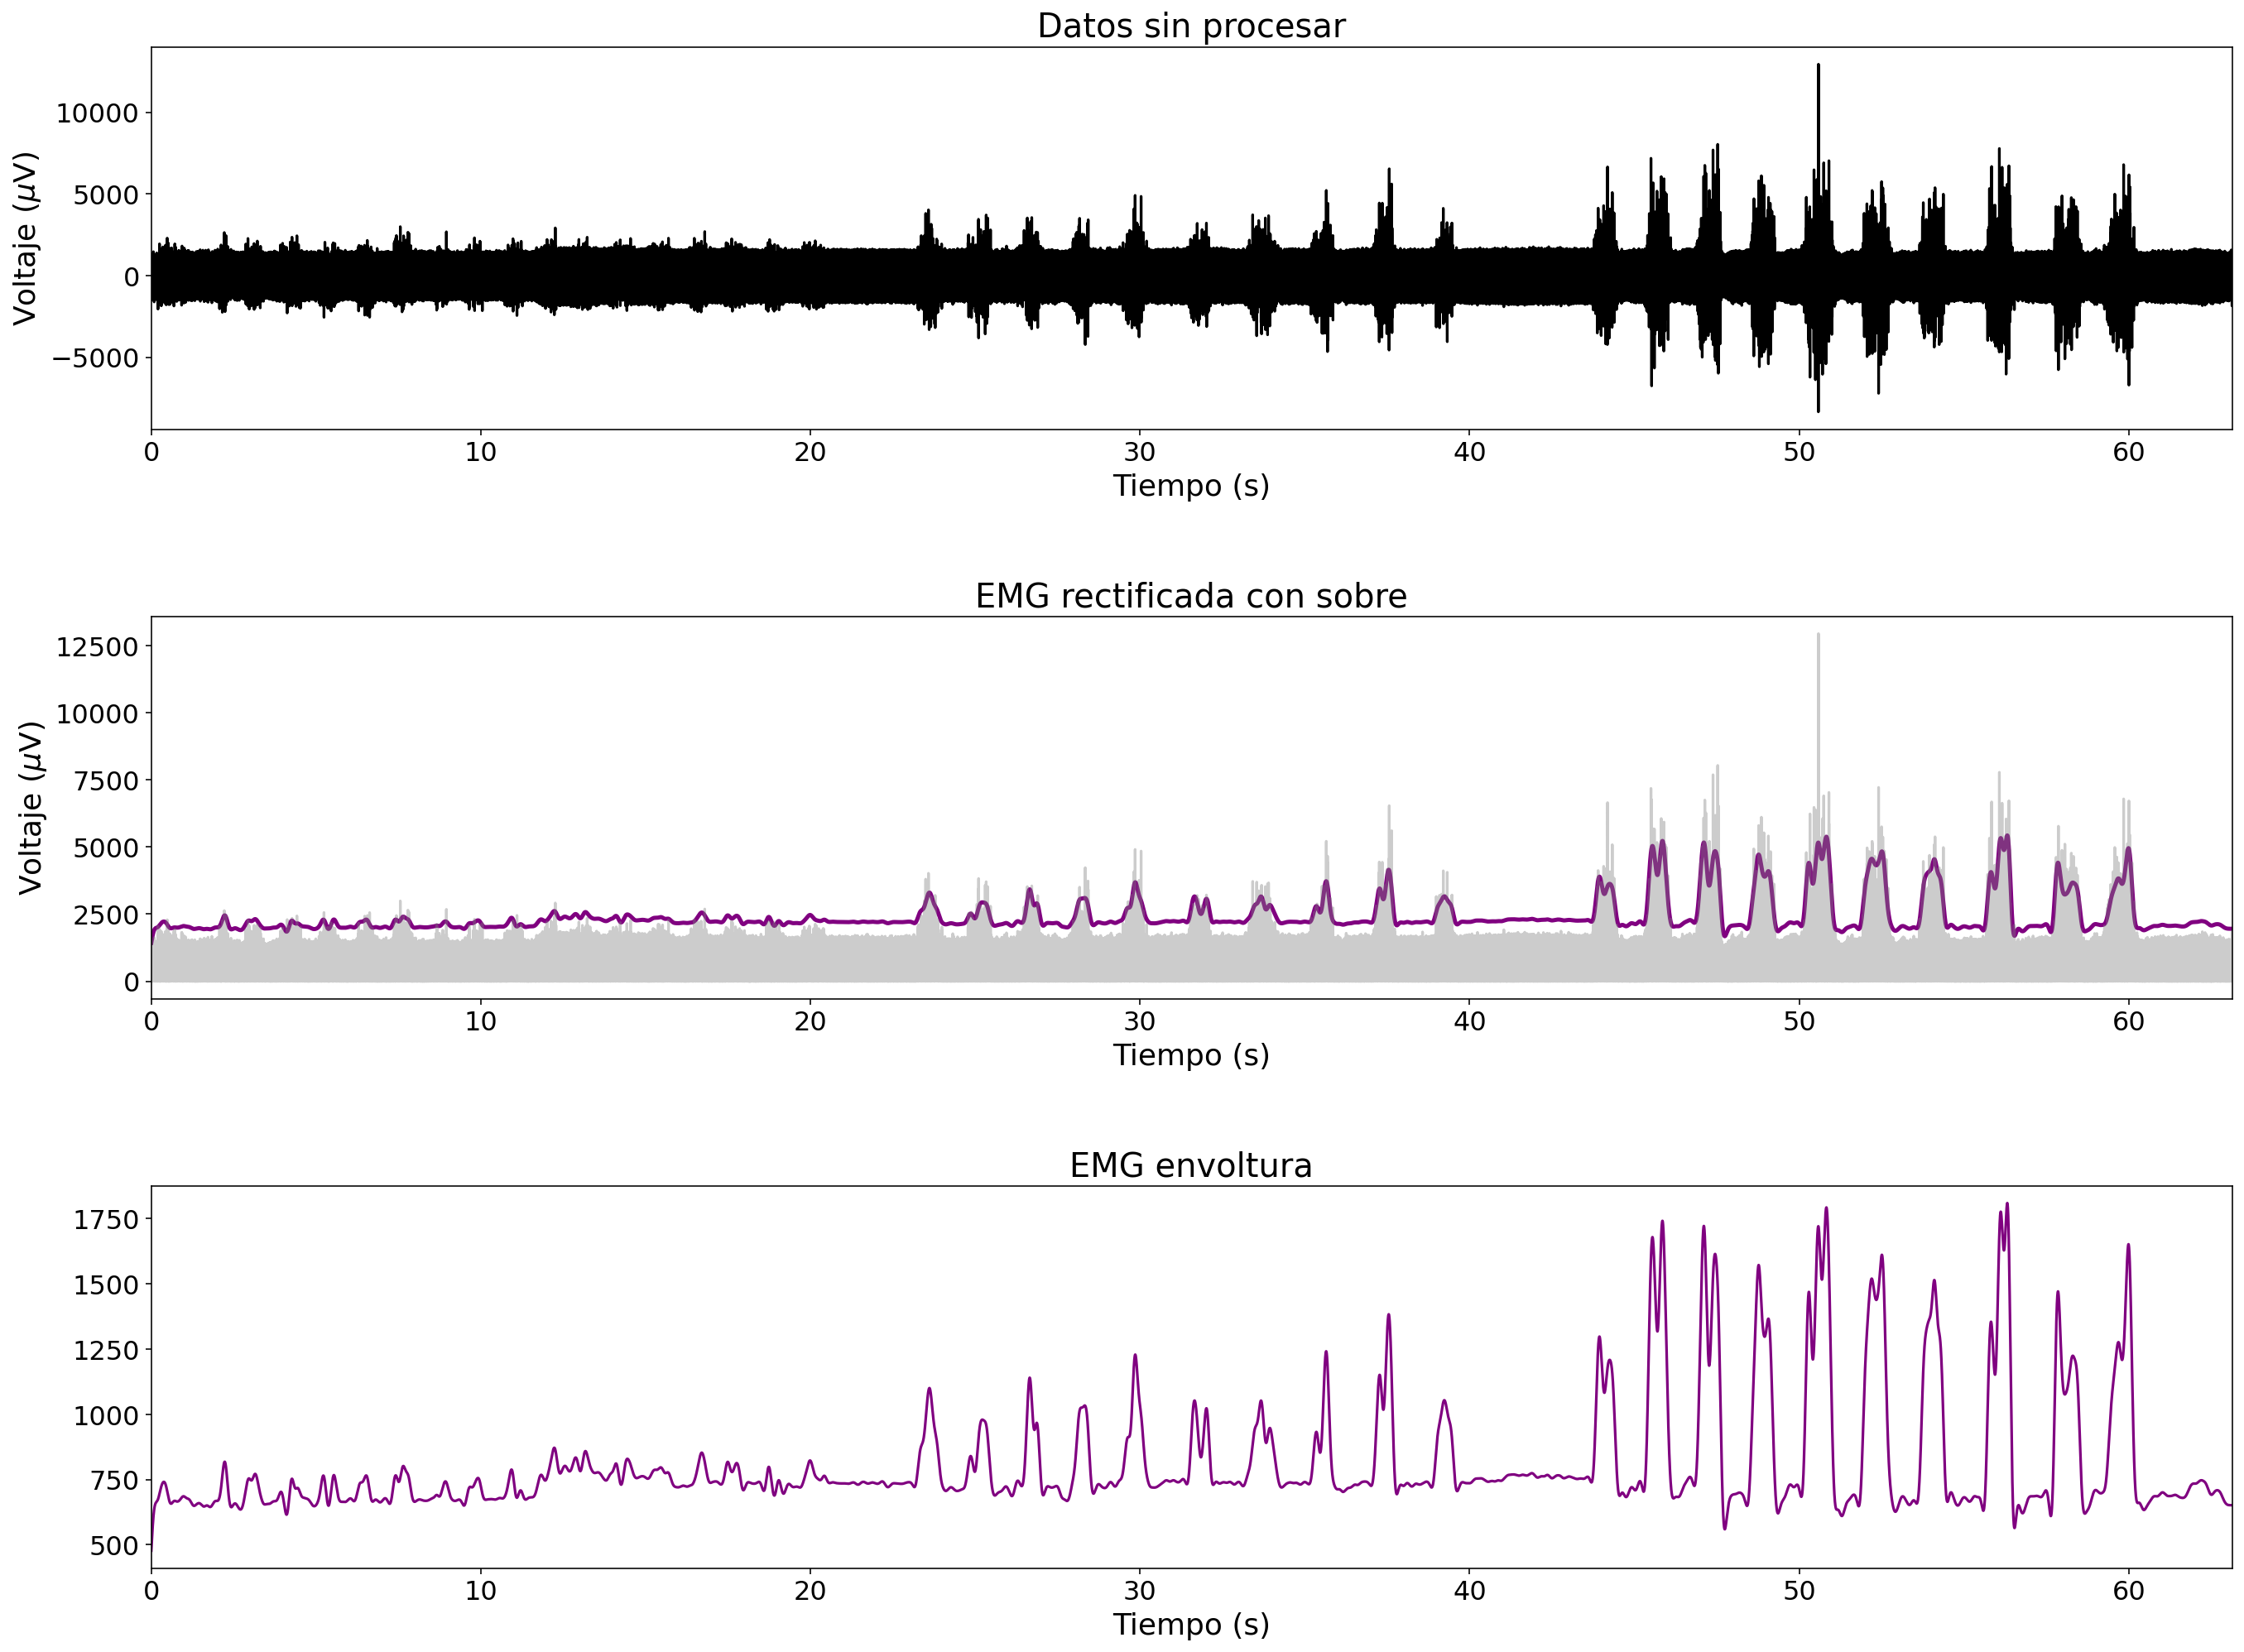

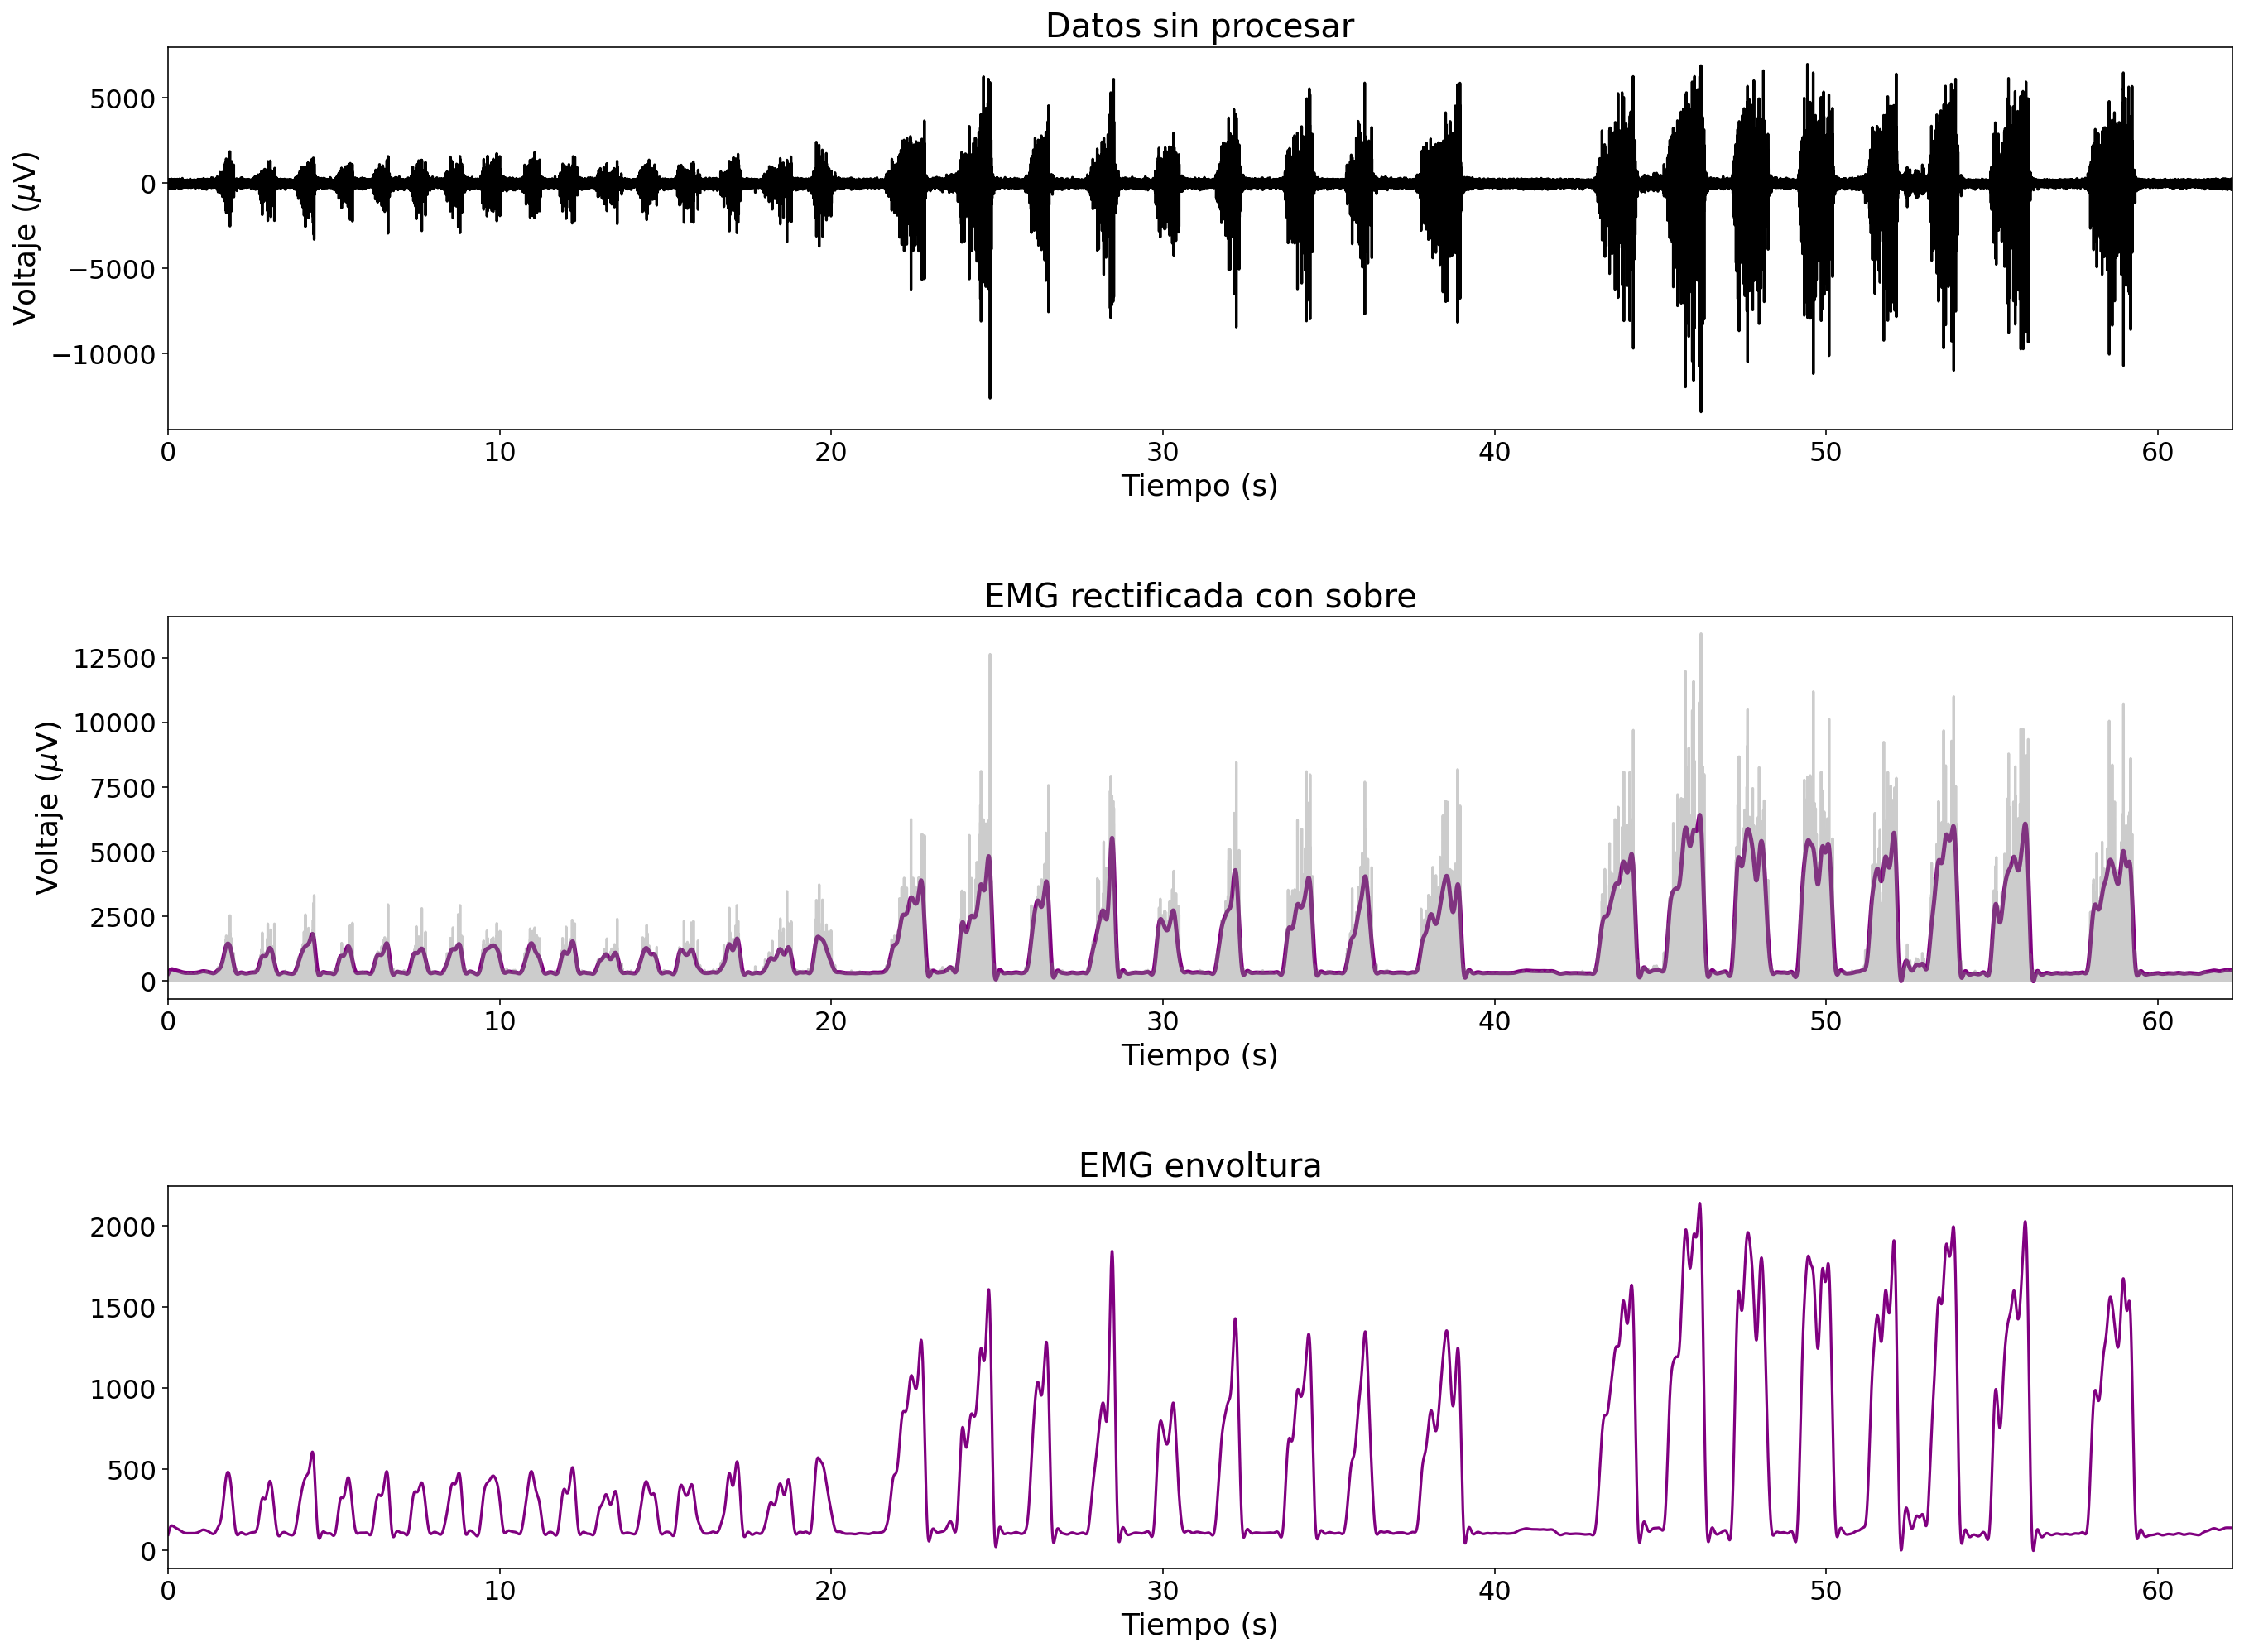

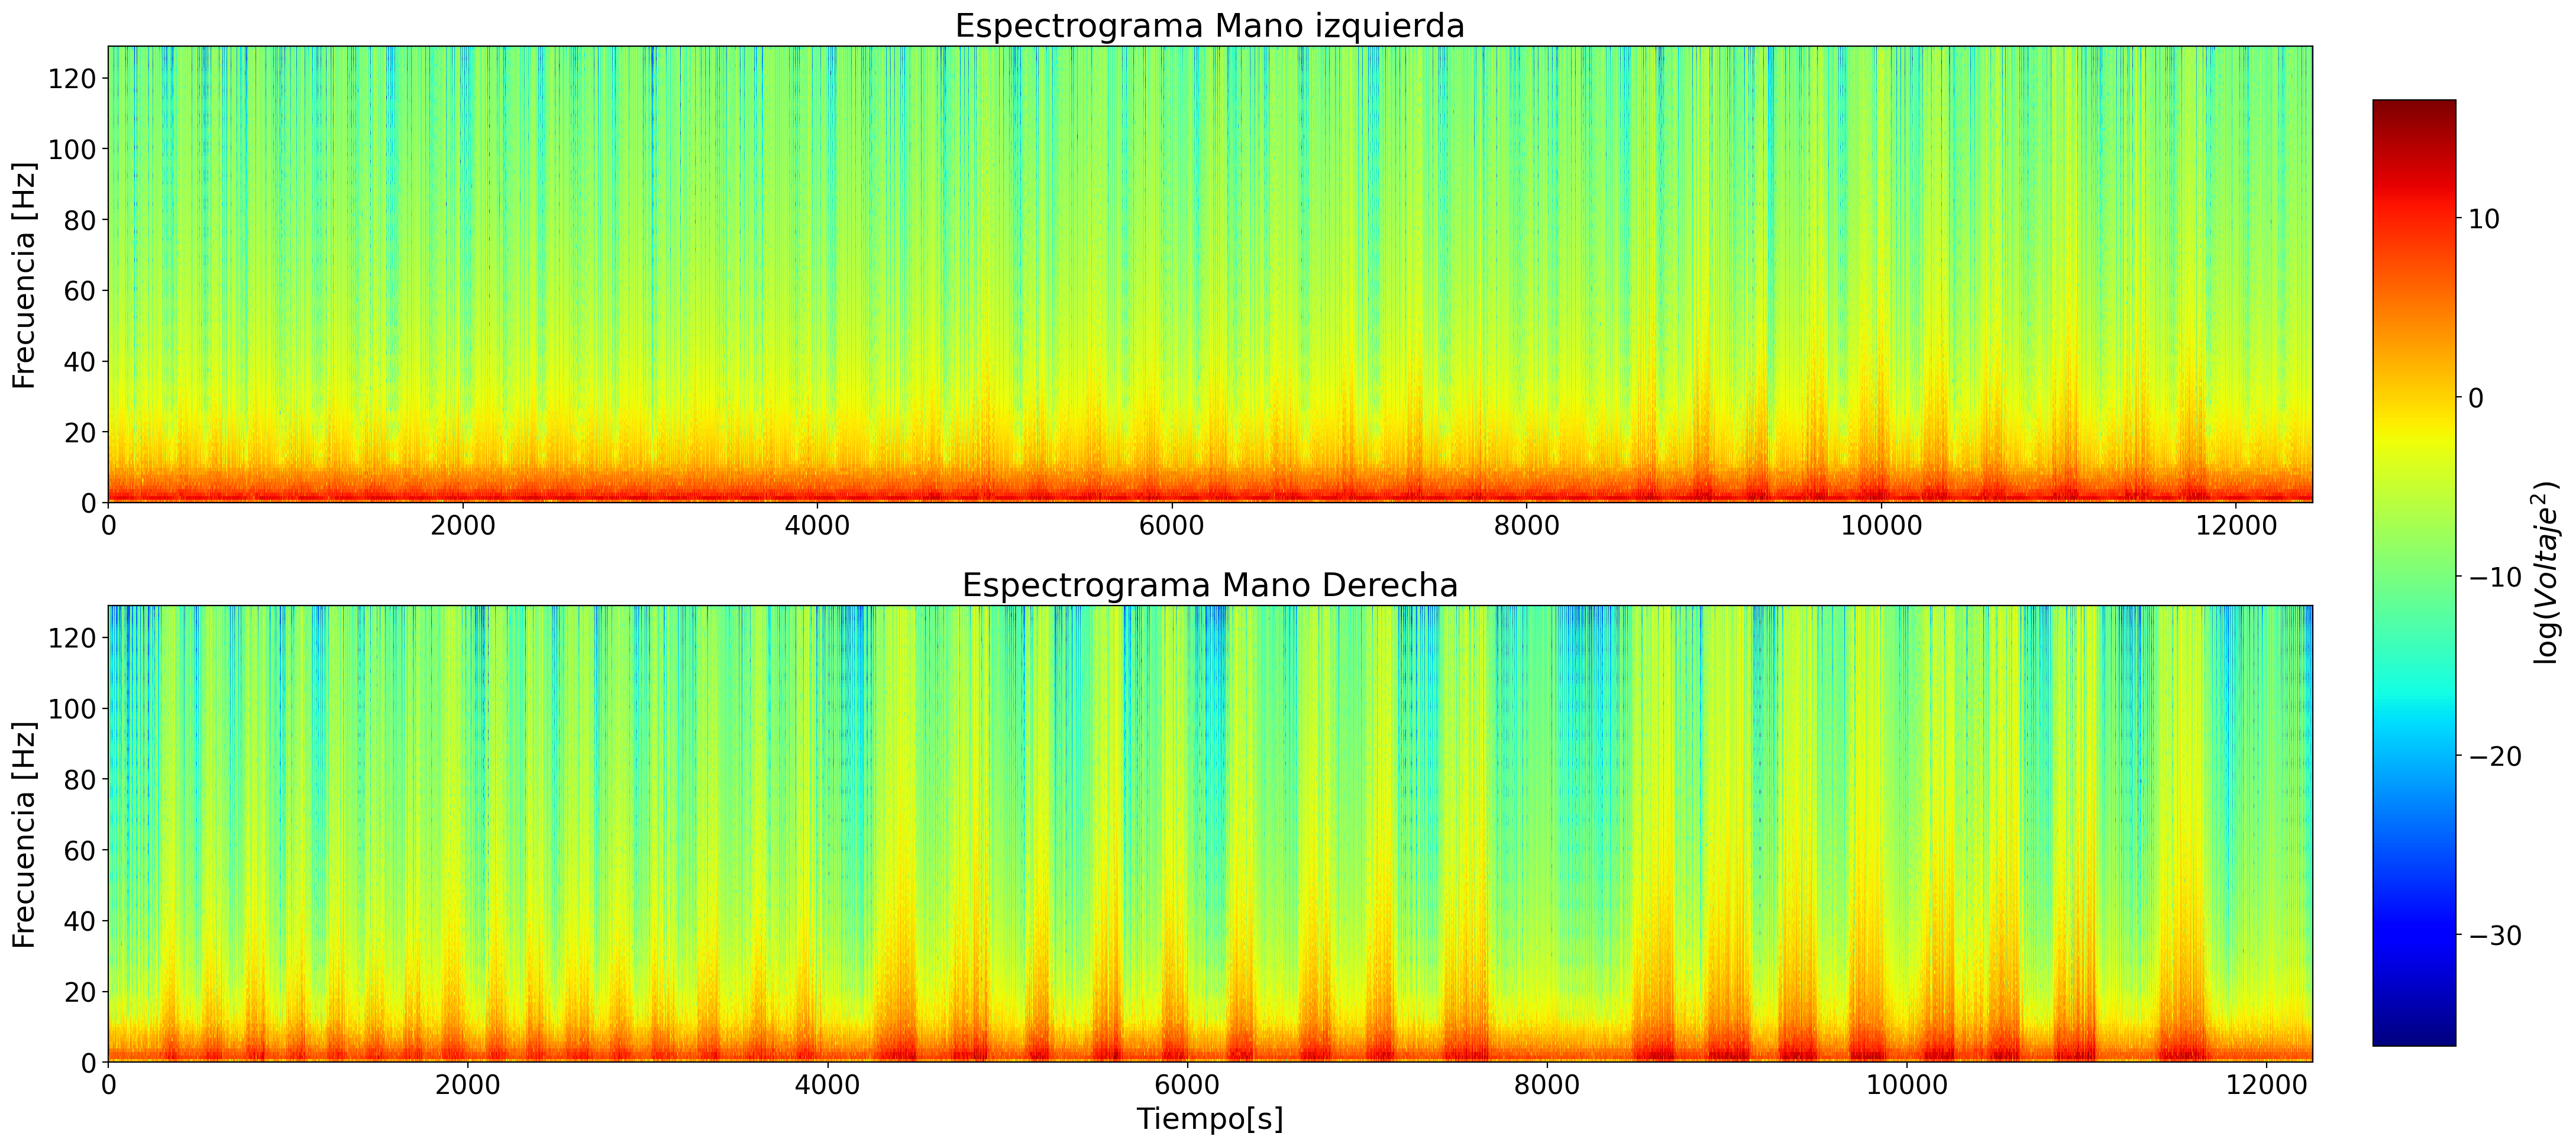

In [34]:
Manoizquierda=EMG('../Registros/S1_EMG_leftHand_gripIntermittent.wav',graph=1)
Manoderecha=EMG('../Registros/S1_EMG_rightHand_gripIntermittent.wav',graph=1)

fig = plt.figure(figsize=(20,10),dpi=100)


#Señal de EMG intermitente cuando se ejerce fuerza en la mano izquierda.
data = Manoizquierda['AbsSeñal']
#sc.signal.spectrogram calcula un espectrograma con transformadas de Fourier consecutivas.
f, t, sxx1 = sc.signal.spectrogram(data,Manoizquierda['FrecMuestreo'],nperseg=None,\
                                   scaling='spectrum')
f = f[:401]
sxx1 = sxx1[:401]
min_sxx1 = np.min(np.log(sxx1))
max_sxx1 = np.max(np.log(sxx1))

#Trazamos la grafica.
plt.subplot(211)  #Sirve para poner más de una gráfica en una misma ventana.
plt.pcolormesh(np.log(sxx1),cmap='jet')   ##Genera un diagrama de pseudocolor con una cuadrícula rectangular no regular.
plt.ylabel('Frecuencia [Hz]')             #Título eje y
plt.title('Espectrograma Mano izquierda') #Título


#Señal de EMG intermitente cuando se ejerce fuerza en la mano derecha.
data = Manoderecha['AbsSeñal']
#sc.signal.spectrogram calcula un espectrograma con transformadas de Fourier consecutivas.
f, t, sxx = sc.signal.spectrogram(data,Manoderecha['FrecMuestreo'],nperseg=None,\
                                  scaling='spectrum')
f = f[:401]
sxx = sxx[:401]

#Trazamos la grafica.
plt.subplot(212)  #Sirve para poner más de una gráfica en una misma ventana.
plt.pcolormesh(np.log(sxx),cmap='jet')   #Genera un diagrama de pseudocolor con una cuadrícula rectangular no regular.
plt.ylabel('Frecuencia [Hz]')            #Título eje y
plt.title('Espectrograma Mano Derecha')  #Título


#Configuración de los espectrogramgas
plt.xlabel('Tiempo[s]')  #Título del eje x

#Traza de la barra derecha.
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.01, .1, 0.035, 0.8])
plt.colorbar(label='log($Voltaje^2$)',cax=cbar_ax,) #Título de la barra.

plt.draw()
plt.tight_layout()

<a id='EspectrodePotencia'></a>
## Espectro de Potencia

Usualmente se trabaja con la transformada de Fourier no directamente, sino a través de  el espectro de potencia, también conocido como la “densidad espectral de  potencia”, PSD (Power Spectral Density).Podemos obtener la densidad espectral de potencia tomando el cuadrado del valor absoluto(amplifica los valores) del DFT, se suele graficar a escala de log 

Debido a que el cuadrado amplifica los valores, se suele graficar en escala log-­log.


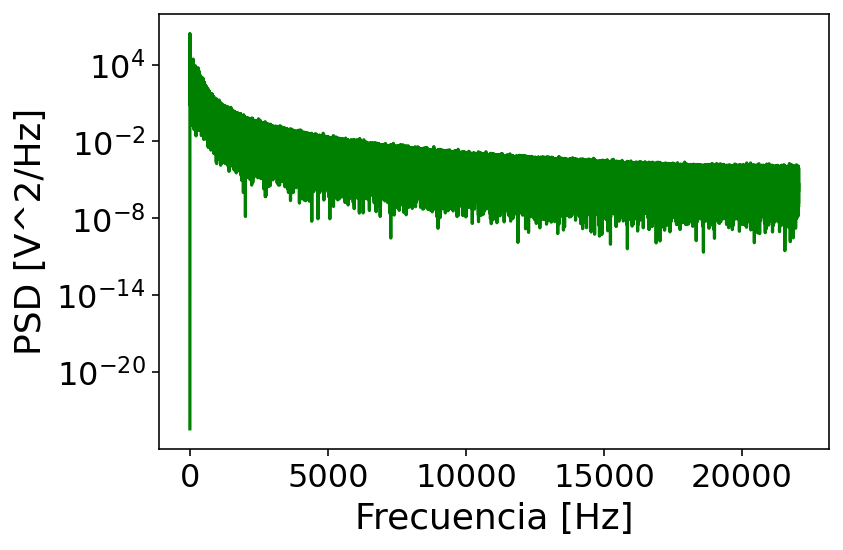

In [35]:
#signal.periodogram calcula la densidad espectral de potencia utilizando un periodograma.
f, Pxx_den = signal.periodogram(data, Manoderecha['FrecMuestreo'])
plt.semilogy(f, Pxx_den,color="green")

#Trazamos la gráfica
plt.xlabel('Frecuencia [Hz]')#Título del eje x
plt.ylabel('PSD [V^2/Hz]')  #Título del eje y
plt.show()

### Referencias

Registros fueron recuperados del repositorio elaborado por la Dra.Erin C. McKiernan y colaboradores, consultado en:
https://github.com/emckiernan/electrophys

Este trabajo fue apoyado por UNAM-DGAPA-PAPIME PE213817 y PE213219.